In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from echo_state_tests import gen_in_out_one_in_subs

from scipy.sparse import csr_matrix

from esn_module import esn

mpl.rcParams['figure.dpi'] = 92

import pdb

import pickle

/home/fschubert/work/py36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [899]:
N = 1000

cf = .1
cf_in = .1

sigm_w = 1.
sigm_w_in = 1.

W = np.random.normal(0.,sigm_w/(cf*N)**.5,(N,N))*(np.random.rand(N,N) <= cf)
W[range(0),range(0)] = 0.

W = csr_matrix(W)

WT = np.array(W.todense()).T
#WTSP = csr_matrix(WT)

w_in = np.random.normal(0.,sigm_w_in,(N))*(np.random.rand(N) <= cf_in)

###
eps_w_out = 0.01
eps_a = .001

## alpha = 0.: only local gradients, 1.: only pop. average gradient.
alpha = 1.


###
T = 500000
T_skip_rec = 10
T_rec = int(T/T_skip_rec)
T_w_o_learn = 5000
T_skip_w_o_learn = 5000

t_ax = np.array(range(T_rec))*T_skip_rec

y_rec = np.ndarray((T_rec,N))
a_rec = np.ndarray((T_rec,N))
w_out_rec = np.ndarray((T_rec,N+1))

y_rec_w_out_learn = np.zeros((T_w_o_learn,N+1))

u_out_w_out_learn = np.zeros((T_w_o_learn,1))

###
reg_fact = 0.01

### delay for xor-problem
tau = 15

In [900]:
nabl_a_exact = np.ndarray((T_rec,N))

In [901]:
nabl_a_approx = np.ndarray((T_rec,N))

In [902]:
E_rec = np.ndarray((T_rec))

In [903]:
u_in, u_out = gen_in_out_one_in_subs(T,tau)
u_in = np.array([u_in]).T
u_out = np.array([u_out]).T

In [904]:
y_init = np.random.rand(N+1)-.5
y_init[0] = 1.

In [905]:
w_out_init = np.random.rand(N+1)-.5
w_out_init[0] = 0.

In [906]:
w_out = np.array(w_out_init)

In [907]:
y = np.array(y_init)

In [908]:
a = np.ones((N))*1.

nabl_a = np.zeros((N))

H = np.array(W.todense())

G = np.zeros((N,N))

dyrho = np.zeros((N))

rho = 1.

In [909]:
for t in tqdm(range(T)):
    
    X_r = W.dot(y[1:])
    X_e = w_in*u_in[t]
    
    X = X_r + X_e 
    
    y[1:] = np.tanh(a*X)
    
    y_rec_w_out_learn[t%T_w_o_learn,:] = y[:]
    
    u_out_w_out_learn[t%T_w_o_learn,0] = u_out[t]
    
    #y_rec_w_out_learn[:-1,:] = y_rec_w_out_learn[1:,:]
    #y_rec_w_out_learn[-1,:] = y[:]
    
    
    if t%T_skip_w_o_learn == 0 and t>=T_w_o_learn:
                
        w_out = (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn)[:,0]
    
    O = y @ w_out
    
    ### update gains
    #'''
    if t>=T_w_o_learn:
        
        #H = (WT * a * (1.-y[1:]**2.)).T
               
        #G = H @ G
               
        #G[range(N),range(N)] += (1.-y[1:]**2.)*X

        #nabl_w_out = (O - u_out[t])*y
        
        
        dyrho = (1.-y[1:]**2.)*(rho * W.dot(dyrho) + X)
        
        dErho = (O-u_out[t])*(w_out[1:] @ dyrho)
        
        rho = rho - eps_a*dErho
        
        rho = np.maximum(rho,0.001)
        
        a[:] = rho
        
        #nabl_a = (O - u_out[t])*(w_out[1:] @ G)
        #nabl_a = np.asarray((O - u_out[t])*(w_out[1:] @ G))[0,:]

        #w_out -= eps_w_out * nabl_w_out
        
        #import pdb
        #pdb.set_trace()
        
        #a -= eps_a * (nabl_a * (1.-alpha) + alpha * nabl_a.mean())

        #a = np.maximum(a,0.001)
    #'''
    ### approximate update gains
    '''
    if t>=T_w_o_learn:
    
        
        nabl_a = (O - u_out[t])*(w_out[1:] * (1.-y[1:]**2.)*X + a*(w_out[1:]*(1.-y[1:]**2.)*X*a).sum())
        #nabl_a = np.asarray((O - u_out[t])*(w_out[1:] @ G))[0,:]

        #w_out -= eps_w_out * nabl_w_out
        
        #import pdb
        #pdb.set_trace()
        
        a -= eps_a * (nabl_a * (1.-alpha) + alpha * nabl_a.mean())

        a = np.maximum(a,0.001)
    '''
    
    
    ####
    if t%T_skip_rec == 0:
        
        t_rec = int(t/T_skip_rec)
        
        y_rec[t_rec,:] = y[1:]
        a_rec[t_rec,:] = a
        w_out_rec[t_rec,:] = w_out
        
        E_rec[t_rec] = (O - u_out[t])**2./2.
        
        #nabl_a_exact[t_rec,:] = nabl_a
        nabl_a_approx[t_rec,:] = nabl_a
    
w_out = (np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out[t-T_w_o_learn+1:t+1,:])[:,0]    
        
        
ESN = esn(N=N)
ESN.W = csr_matrix(W)
ESN.w_in = np.array([w_in]).T
ESN.w_out = np.array([w_out])
ESN.gain = a

save_dict = {"ESN":ESN,"tau":tau}

pickle.dump(save_dict, open( "../data/RTRL/save_dict_tau"+"_"+ str(tau) + ".p", "wb" ))

In [896]:
textwidth = 5.5532
path = "../plots/RTRL/"

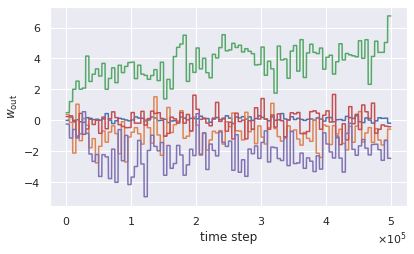

In [910]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.plot(t_ax[::10],w_out_rec[::10,:5])
ax.set_xlabel("time step")
ax.set_ylabel("$w_{\\rm out}$")
ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,3),useMathText=True)

fig.tight_layout(pad=0.)

#fig.savefig(path+"w_out.png",dpi=600)
#fig.savefig(path+"w_out.pdf")

plt.show()

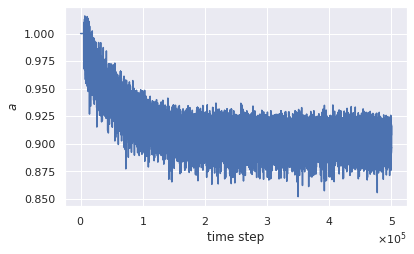

In [911]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.plot(t_ax,a_rec[:,0])
ax.set_xlabel("time step")
ax.set_ylabel("$a$")
ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,3),useMathText=True)

fig.tight_layout(pad=0.)

#fig.savefig(path+"gains.png",dpi=600)
#fig.savefig(path+"gains.pdf",dpi=600)

#plt.ylim([0.,2.])

plt.show()

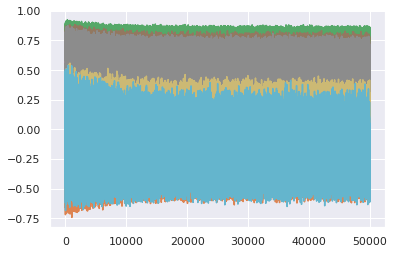

In [912]:
plt.plot(y_rec[:,:10])
plt.show()

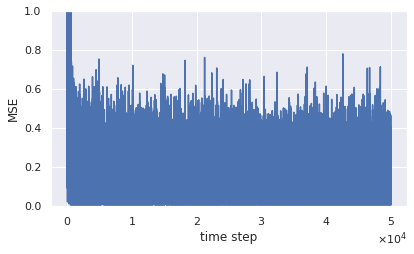

In [913]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.plot(E_rec**.5)
ax.set_ylim([0.,1.])
ax.set_xlabel("time step")
ax.set_ylabel("MSE")
ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,3),useMathText=True)

fig.tight_layout(pad=0.)

fig.savefig(path+"error.png",dpi=600)
fig.savefig(path+"error.pdf",dpi=600)

plt.show()

In [847]:
T_test = 10000

u_in_learn,u_out_learn = gen_in_out_one_in_subs(T_test,tau)
u_in_test,u_out_test = gen_in_out_one_in_subs(T_test,tau)

In [848]:
ESN.learn_w_out(u_in_learn,u_out_learn)

u_pred = ESN.predict_data(u_in_test)

In [849]:
ESN_unpert = esn(N=N,cf_w_in=cf_in)
ESN_unpert.learn_w_out(u_in_learn,u_out_learn)

u_pred_unpert = ESN_unpert.predict_data(u_in_test)

In [850]:
ESN_gains = esn(N=N,cf_w_in=cf_in)
ESN_gains.gain = a

ESN_gains.learn_w_out(u_in_learn,u_out_learn)

u_pred_gains = ESN_gains.predict_data(u_in_test)

In [851]:
ESN_rescale = esn(N=N,cf_w_in=cf_in)
ESN_rescale.gain *= .85 #np.abs(l_adapt).max()

ESN_rescale.learn_w_out(u_in_learn,u_out_learn)

u_pred_rescale = ESN_rescale.predict_data(u_in_test)

In [852]:
l_unpert = np.linalg.eigvals(ESN_unpert.W_gain())
l_unpert_gains = np.linalg.eigvals(ESN_gains.W_gain())
l_adapt = np.linalg.eigvals(ESN.W_gain())
l_rescale = np.linalg.eigvals(ESN_rescale.W_gain())

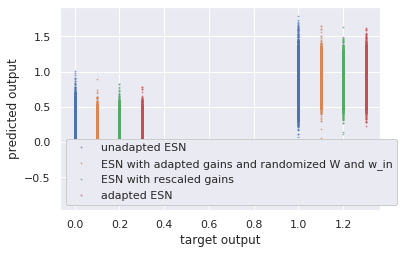

In [853]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))

ax.plot(u_out_test,u_pred_unpert,'.',alpha=.5,markersize=2,label="unadapted ESN")
ax.plot(u_out_test+.1,u_pred_gains,'.',alpha=.5,markersize=2,label="ESN with adapted gains and randomized W and w_in")
ax.plot(u_out_test+.2,u_pred_rescale,'.',alpha=.5,markersize=2,label="ESN with rescaled gains")
ax.plot(u_out_test+.3,u_pred,'.',alpha=.5,markersize=2,label="adapted ESN")

ax.legend(framealpha=1.)
ax.set_xlabel("target output")
ax.set_ylabel("predicted output")

fig.tight_layout(pad=0.)

fig.savefig(path+"target_vs_prediction.png",dpi=600)
#fig.savefig(path+"target_vs_prediction.pdf",dpi=600)

plt.show()

In [854]:
print("Correlation plain vanilla: " + str(np.corrcoef(u_out_test,u_pred_unpert)[1,0]))
print("Correlation plain vanilla with copied adapted gains: " + str(np.corrcoef(u_out_test,u_pred_gains)[1,0]))
print("Correlation plain vanilla with rescaled gains: " + str(np.corrcoef(u_out_test,u_pred_rescale)[1,0]))
print("Correlation after adaptation: " + str(np.corrcoef(u_out_test,u_pred)[1,0]))

Correlation plain vanilla: 0.8366926373503735
Correlation plain vanilla with copied adapted gains: 0.9125685678010913
Correlation plain vanilla with rescaled gains: 0.8987436024354247
Correlation after adaptation: 0.9028859372199659


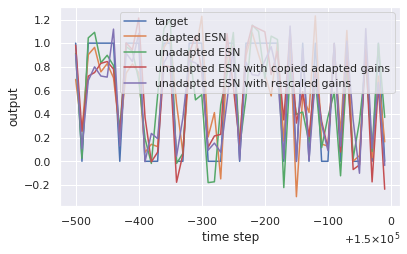

In [855]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.plot(t_ax[-50:],u_out_test[-50:],alpha=1.,label="target")
ax.plot(t_ax[-50:],u_pred[-50:],alpha=1.,label="adapted ESN")
ax.plot(t_ax[-50:],u_pred_unpert[-50:],alpha=1.,label="unadapted ESN")
ax.plot(t_ax[-50:],u_pred_gains[-50:],alpha=1.,label="unadapted ESN with copied adapted gains")
ax.plot(t_ax[-50:],u_pred_rescale[-50:],alpha=1.,label="unadapted ESN with rescaled gains")
ax.legend(loc=1)
ax.set_xlabel("time step")
ax.set_ylabel("output")
ax.ticklabel_format(axis='x',style='sci',scilimits=(-2,3),useOffset=T,useMathText=True)

fig.tight_layout(pad=0.)

fig.savefig(path+"target_ESN_compare.png",dpi=600)
fig.savefig(path+"target_ESN_compare.pdf",dpi=600)

plt.show()

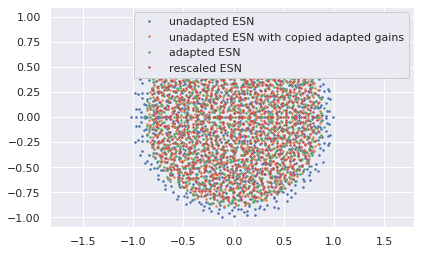

In [856]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.plot(l_unpert.real,l_unpert.imag,'.',markersize=3,label="unadapted ESN")
ax.plot(l_unpert_gains.real,l_unpert_gains.imag,'.',markersize=3,label="unadapted ESN with copied adapted gains")
ax.plot(l_adapt.real,l_adapt.imag,'.',markersize=3,label="adapted ESN")
ax.plot(l_rescale.real,l_rescale.imag,'.',markersize=3,label="rescaled ESN")
ax.axis("equal")
ax.legend(framealpha=1.)

fig.tight_layout(pad=0.)

fig.savefig(path+"eigvals.png",dpi=600)
fig.savefig(path+"eigvals.pdf",dpi=600)

plt.show()

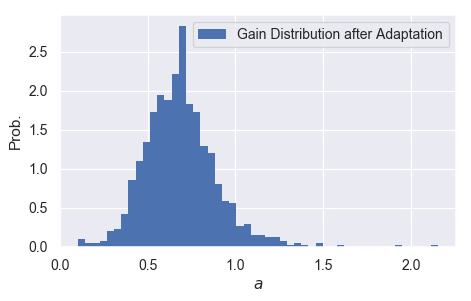

In [359]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))
ax.hist(a,bins=50,density=True,histtype='step',lw=0,fill=True,label="Gain Distribution after Adaptation")
ax.set_xlabel("$a$")
ax.set_ylabel("Prob.")
ax.legend()
plt.show()

In [914]:
l = np.linalg.eigvals(ESN.W_gain())
print(np.abs(l).max())

0.9355598088583233
